# Individual Assignment 4: **Missing Data**
The selected project was topic A.

After selecting a few datasets without missing data for analysis, we will induce missing data on them with different mechanisms. Then, we will apply different techniques to deal with this missing data and compare the different missing data mechanisms and techniques.

The datasets chosen to experiment were:
- ...
- ...

The missing data mechanisms were MCAR, MAR and MNAR.

We experimented with the following techniques:
- ...
- ...

Finally, we evaluated these techniques and were able to compare them using these metrics:
- ...
- ...

The index for the different sections of the notebook is as follows:
1. Introduction
2. Datasets and Preprocessing
3. Missing Data Mechanisms
4. Missing Data Techniques
5. Evaluation
6. Conclusion

<!--ipykernel==6.29.5-->

In [29]:
%pip install -qU pandas==2.2.3 scikit-learn==1.6.0 seaborn==0.13.2 matplotlib==3.10.0 mdatagen==0.1.71 missingno==0.5.2 setuptools==75.6.0

Note: you may need to restart the kernel to use updated packages.


Note that the notebook was run using Python 3.12.3 <!-- also tested on Google Collab Python 3.??.? -->

In [30]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from mdatagen.univariate.uMCAR import uMCAR
from mdatagen.univariate.uMAR import uMAR
from mdatagen.univariate.uMNAR import uMNAR
from mdatagen.multivariate.mMCAR import mMCAR
from mdatagen.multivariate.mMAR import mMAR
from mdatagen.multivariate.mMNAR import mMNAR

from scipy.stats import ks_2samp

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Callable

In [31]:
def load_datasets():
    """Loads the datasets and returns a dictionary of dataset labels and dataframes"""
    mobile_price = pd.read_csv("mobile_price.csv")
    mobile_price.rename(columns={"price_range": "target"}, inplace=True)
    print(mobile_price.columns)
    return {
        "mobile_price": mobile_price,
    }

In [32]:
RANDOM_STATE = 42

In [33]:
class MyImputer:
    def __init__(self, general = None, numerical = None, binary = None):
        self.general = general
        self.numerical = numerical
        self.binary = binary

In [34]:
MISSING_RATES = [10]
MISSING_TECHNIQUES = {
    "Simple": MyImputer(
        numerical=SimpleImputer(strategy="mean"),
        binary=SimpleImputer(strategy="most_frequent"),
    ),
    "MICE": MyImputer(general=IterativeImputer(max_iter=50, random_state=RANDOM_STATE)),
    "KNN": MyImputer(general=KNNImputer()),
    # "NONE": None,
}

MODELS = [LogisticRegression(), RandomForestClassifier(), MLPClassifier(max_iter=1000)]
METRICS = ["accuracy", "precision", "recall", "f1"]

In [35]:
def mcar_univariate(X, y, missing_rate) -> pd.DataFrame:
    generator = uMCAR(X=X, y=y, missing_rate=missing_rate, method="max")
    return generator.random()

def mcar_multivariate(X, y, missing_rate) -> pd.DataFrame:
    generator = mMCAR(X=X, y=y, missing_rate=missing_rate)
    df = generator.random()
    df["target"] = y
    return df

def mar_univariate(X, y, missing_rate) -> pd.DataFrame:
    generator = uMAR(X=X, y=y, missing_rate=missing_rate)
    return generator.lowest()

def mar_multivariate(X, y, missing_rate) -> pd.DataFrame:
    generator = mMAR(X=X, y=y, n_xmiss=2)
    # Here, we need to divide by 2, otherwise too much missing data will be generated
    new_df = generator.correlated(missing_rate=missing_rate/2)
    new_df["target"] = y
    return new_df

def mnar_univariate(X, y, missing_rate) -> pd.DataFrame:
    generator = uMNAR(X=X, y=y, missing_rate=missing_rate, threshold=0)
    return generator.run()

def mnar_multivariate(X, y, missing_rate) -> pd.DataFrame:
    generator = mMNAR(X=X, y=y, n_xmiss=2, threshold=0)
    new_df = generator.MBOUV(missing_rate=missing_rate)
    new_df["target"] = y
    return new_df

MISSING_MECHANISMS = {
    "Uni MCAR": mcar_univariate,
    "Multi MCAR": mcar_multivariate,
    "Uni MAR": mar_univariate,
    "Multi MAR": mar_multivariate,
    "Uni MNAR": mnar_univariate,
    "Multi MNAR": mnar_multivariate,
}

In [36]:
def count_missing_values(df: pd.DataFrame) -> pd.Series:
    count = df.isna().sum()
    return count[count > 0]
def print_missing_values(count: pd.Series) -> None:
    if len(count) == 0:
        return print("No missing values")
    print(count)

In [37]:
initial_dfs = load_datasets()

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'target'],
      dtype='object')


We selected datasets without missing values to completely control the present missing data mechanisms.

In [38]:
for label, df in initial_dfs.items():
    print(f"Dataset {label}")
    print_missing_values(count_missing_values(df))

Dataset mobile_price
No missing values


In [39]:
for label, df in initial_dfs.items():
    print(f"Dataset {label}")
    print(df.info())
    print(df["target"].value_counts())

Dataset mobile_price
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   

In [40]:
missing_data_dfs = []
for dataset_label, df in initial_dfs.items():
    for missing_rate in MISSING_RATES:
        # Target variable should be named "target"
        X = df.drop("target", axis=1)
        y = df["target"].values

        for missing_mechanism_label, missing_data_generator in MISSING_MECHANISMS.items():
            new_df = missing_data_generator(X=X, y=y, missing_rate=missing_rate)

            missing_data_dfs.append({
                "mechanism": missing_mechanism_label,
                "missing_rate": missing_rate,
                "dataset": dataset_label,
                "df": new_df,
                "original_df": df,
            })
            print(f"Missing Rate: {missing_rate}, Missing Type: {missing_mechanism_label}")
            print_missing_values(count_missing_values(new_df))

Missing Rate: 10, Missing Type: Uni MCAR
ram    200
dtype: int64
Missing Rate: 10, Missing Type: Multi MCAR
battery_power    206
blue             222
clock_speed      188
dual_sim         208
fc               203
four_g           190
int_memory       174
m_dep            215
mobile_wt        178
n_cores          182
pc               186
px_height        202
px_width         213
ram              219
sc_h             213
sc_w             201
talk_time        212
three_g          206
touch_screen     200
wifi             182
dtype: int64
Missing Rate: 10, Missing Type: Uni MAR
ram    200
dtype: int64
Missing Rate: 10, Missing Type: Multi MAR
battery_power    200
int_memory       200
mobile_wt        200
pc               200
px_width         200
ram              200
sc_w             200
three_g          200
touch_screen     200
wifi             200
dtype: int64
Missing Rate: 10, Missing Type: Uni MNAR
ram    200
dtype: int64
Missing Rate: 10, Missing Type: Multi MNAR
battery_power    294
b

In [41]:
def get_missing_data_accuracy(
    features: list[str],
    processed_feature_indices: list[int],
    missing_X: pd.DataFrame,
    imputed_X: np.ndarray,
    original_X: pd.DataFrame,
    metric_calculator: Callable[[np.ndarray, np.ndarray], float],
) -> list[float]:
    accuracy = []
    for feature, processed_f_idx in zip(features, processed_feature_indices):
        missing_mask = missing_X[feature].isna()    # row-wise checks for this feature
        if missing_mask.any():
            true_values = original_X.loc[missing_mask, feature]

            # need the processed feature index here because of type np.ndarray
            imputed_values = imputed_X[missing_mask, processed_f_idx]

            accuracy_measure = metric_calculator(true_values, imputed_values)
            accuracy.append(accuracy_measure)
    return accuracy

def get_numerical_pac(
    numerical_features: list[str],
    processed_feature_indices: list[int],
    missing_X: pd.DataFrame,
    imputed_X: np.ndarray,
    original_X: pd.DataFrame,
):
    """Calculates the predictive accuracy for numerical features."""
    return get_missing_data_accuracy(
        numerical_features,
        processed_feature_indices,
        missing_X,
        imputed_X,
        original_X,
        mean_absolute_error,
    )

def get_binary_pac(
    binary_features: list[str],
    processed_feature_indices: list[int],
    missing_X: pd.DataFrame,
    imputed_X: np.ndarray,
    original_X: pd.DataFrame,
):
    """Calculates the predictive accuracy for binary features."""
    # print(imputed_X[:, [missing_X.columns.get_loc(feature) for feature in binary_features]])
    return get_missing_data_accuracy(
        binary_features,
        processed_feature_indices,
        missing_X,
        imputed_X,
        original_X,
        accuracy_score,
    )

def get_dac(
    numerical_features: list[str],
    processed_feature_indices: list[int],
    missing_X: pd.DataFrame,
    imputed_X: np.ndarray,
    original_X: pd.DataFrame,
):
    """Calculates the distributional accuracy (only for numerical features)."""
    ks_calculator = lambda true, imputed: ks_2samp(true, imputed)[0]
    return get_missing_data_accuracy(
        numerical_features,
        processed_feature_indices,
        missing_X,
        imputed_X,
        original_X,
        ks_calculator,
    )


In [42]:
class BinaryPostProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # print("Before")
        # print(sum(X > 1))
        # print(sum(X < 0))
        # print(sum(X == np.nan))
        # print(len(X))
        # print(X)
        X = np.clip(X, 0, 1)
        X = np.random.binomial(1, X)    # Apply probabilistic rounding on all features in this subset
        # print("After")
        # print(X)
        return X

    def get_feature_names_out(self, input_features):
        return input_features

In [43]:
score_results = []
pac_results = []
dac_results = []
for df_info in missing_data_dfs:
    df = df_info["df"]
    original_X = df_info["original_df"].drop("target", axis=1)
    missing_rate = df_info["missing_rate"]
    mechanism = df_info["mechanism"]
    dataset = df_info["dataset"]

    X = df.drop("target", axis=1)
    y = df["target"]

    binary_features = [i for i, col in enumerate(original_X.columns) if original_X[col].nunique() == 2]
    numerical_features = [i for i, col in enumerate(X.columns) if col not in X.columns[binary_features]]

    idx_to_label = lambda feature_idx: X.columns[feature_idx]
    binary_features_labels = list(map(idx_to_label, binary_features))
    numerical_features_labels = list(map(idx_to_label, numerical_features))


    for imputer_label, imputer in MISSING_TECHNIQUES.items():
        # Avoid using ColumnTransformer since it changes the order of the columns
        # And converts the dataframe to a numpy array
        if imputer.general is None:
            # Use separate imputers for numerical and binary columns
            preprocessor = ColumnTransformer([
                ('num', Pipeline([
                    ('imputer', imputer.numerical),         # Apply numerical imputer
                    ('scaler', StandardScaler())
                ]), numerical_features),
                ('binary', imputer.binary, binary_features) # Apply binary imputer
            ], remainder="passthrough")
            get_processed_feature_names = preprocessor.get_feature_names_out
        else:
            # Use just one imputer for everything
            col_transformer = ColumnTransformer([
                ('num', StandardScaler(), numerical_features),   # Scale only numerical features
                ('bin', BinaryPostProcessor(), binary_features), # Probabilistic rounding for binary features
            ], remainder="passthrough")
            preprocessor = Pipeline([
                ('imputer', imputer.general),               # Apply the general imputer to all columns
                ('column_transform', col_transformer)
            ])
            get_processed_feature_names = col_transformer.get_feature_names_out

        # Fit on the complete data but it will be fit again to evaluate classification error
        # When evaluating classification error, it will be trained only on the training data
        imputed_X = preprocessor.fit_transform(X)
        processed_feature_names = get_processed_feature_names()#preprocessor.get_feature_names_out()

        processed_numerical_feature_indices = [i for i, f in enumerate(processed_feature_names) if f.startswith("num")]
        processed_binary_feature_indices = [i for i, f in enumerate(processed_feature_names) if f.startswith("bin")]

        print("----------------------------------------------------")
        print(mechanism)
        print(imputer_label)
        print("Feature names")
        print(processed_feature_names)
        print(processed_numerical_feature_indices)
        print(processed_binary_feature_indices)

        numerical_pacs = get_numerical_pac(numerical_features_labels, processed_numerical_feature_indices, X, imputed_X, original_X)
        binary_pacs = get_binary_pac(binary_features_labels, processed_binary_feature_indices, X, imputed_X, original_X)

        num_pac_avg = np.mean(numerical_pacs) if len(numerical_pacs) > 0 else np.nan
        bin_pac_avg = np.mean(binary_pacs) if len(binary_pacs) > 0 else np.nan

        print("Numerical PACs (MSE)")
        print(numerical_pacs)
        print(num_pac_avg)
        print("Binary PACs (Accuracy)")
        print(binary_pacs)
        print(bin_pac_avg)

        pac_results.append({
            "imputer": imputer_label,
            "mechanism": mechanism,
            "missing_rate": missing_rate,
            "dataset": dataset,
            "numerical_pac": num_pac_avg,
            "binary_pac": bin_pac_avg,
        })

        numerical_dacs = get_dac(numerical_features_labels, processed_numerical_feature_indices, X, imputed_X, original_X)
        dac_avg = np.mean(numerical_dacs) if len(numerical_dacs) > 0 else np.nan
        print("Numerical DACs")
        print(numerical_dacs)
        print(dac_avg)

        dac_results.append({
            "imputer": imputer_label,
            "mechanism": mechanism,
            "missing_rate": missing_rate,
            "dataset": dataset,
            "numerical_dac": dac_avg,
        })

        for model in MODELS:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])

            scores = cross_val_score(pipeline, X=X, y=y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE))
            score_results.append({
                "imputer": imputer_label,
                "model": model,
                "missing_rate": missing_rate,
                "mechanism": mechanism,
                "dataset": dataset,
                "mean_accuracy": np.mean(scores),
                "std_accuracy": np.std(scores),
            })

----------------------------------------------------
Uni MCAR
Simple
Feature names
['num__battery_power' 'num__clock_speed' 'num__fc' 'num__int_memory'
 'num__m_dep' 'num__mobile_wt' 'num__n_cores' 'num__pc' 'num__px_height'
 'num__px_width' 'num__ram' 'num__sc_h' 'num__sc_w' 'num__talk_time'
 'binary__blue' 'binary__dual_sim' 'binary__four_g' 'binary__three_g'
 'binary__touch_screen' 'binary__wifi']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[14, 15, 16, 17, 18, 19]
Numerical PACs (MSE)
[2167.16]
2167.16
Binary PACs (Accuracy)
[]
nan
Numerical DACs
[np.float64(1.0)]
1.0
----------------------------------------------------
Uni MCAR
MICE
Feature names
['num__x0' 'num__x2' 'num__x4' 'num__x6' 'num__x7' 'num__x8' 'num__x9'
 'num__x10' 'num__x11' 'num__x12' 'num__x13' 'num__x14' 'num__x15'
 'num__x16' 'bin__x1' 'bin__x3' 'bin__x5' 'bin__x17' 'bin__x18' 'bin__x19']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[14, 15, 16, 17, 18, 19]
Numerical PACs (MSE)
[2167.1599979693856]
2167.1599

/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib

----------------------------------------------------
Multi MNAR
MICE
Feature names
['num__x0' 'num__x2' 'num__x4' 'num__x6' 'num__x7' 'num__x8' 'num__x9'
 'num__x10' 'num__x11' 'num__x12' 'num__x13' 'num__x14' 'num__x15'
 'num__x16' 'bin__x1' 'bin__x3' 'bin__x5' 'bin__x17' 'bin__x18' 'bin__x19']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[14, 15, 16, 17, 18, 19]
Numerical PACs (MSE)
[599.6052465176936, 0.4978624223467507, 0.5595493873871206, 5.08822890140157, 0.09816271972754964, 84.12808885295465, 1.012659895317657, 0.6165773334033073, 89.69827492210803, 618.848013078404, 418.863649492856, 5.712869283562023, 0.6567299364364947, 2.971685790920704]
130.59697132389425
Binary PACs (Accuracy)
[0.5303030303030303, 0.43137254901960786, 0.5606936416184971, 0.305, 0.3793103448275862, 0.46919431279620855]
0.4459789797608216
Numerical DACs
[np.float64(1.0), np.float64(1.0), np.float64(0.6666666666666666), np.float64(1.0), np.float64(0.9593023255813954), np.float64(1.0), np.float64(1.0), np.f

/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib

## Classification Error

In [44]:
filename = "results.csv"

In [45]:
print(len(score_results))
score_results_df = pd.DataFrame(score_results)
score_results_df.to_csv(filename, index=False)

54


In [46]:
score_results_df = pd.read_csv(filename)
score_results_df.head()

,imputer,model,missing_rate,mechanism,dataset,mean_accuracy,std_accuracy
0,Simple,LogisticRegression(),10,Uni MCAR,mobile_price,0.8440,0.006819
1,Simple,RandomForestClassifier(),10,Uni MCAR,mobile_price,0.8055,0.015033
2,Simple,MLPClassifier(max_iter=1000),10,Uni MCAR,mobile_price,0.7760,0.016248
3,MICE,LogisticRegression(),10,Uni MCAR,mobile_price,0.8445,0.006595
4,MICE,RandomForestClassifier(),10,Uni MCAR,mobile_price,0.8120,0.017132


In [47]:
selected_missing_rate = MISSING_RATES[0]
filtered_results_df = score_results_df[score_results_df['missing_rate'] == selected_missing_rate]

# Group by mechanism and imputer, averaging over mean_accuracy
grouped_df = (
    filtered_results_df
    .groupby(['mechanism', 'imputer'])['mean_accuracy']
    .mean()
    .reset_index()
)
grouped_df

,mechanism,imputer,mean_accuracy
0,Multi MAR,KNN,0.805667
1,Multi MAR,MICE,0.808333
2,Multi MAR,Simple,0.804833
3,Multi MCAR,KNN,0.794167
4,Multi MCAR,MICE,0.789000
5,Multi MCAR,Simple,0.787000
6,Multi MNAR,KNN,0.698333
7,Multi MNAR,MICE,0.740333
8,Multi MNAR,Simple,0.737000
9,Uni MAR,KNN,0.819667


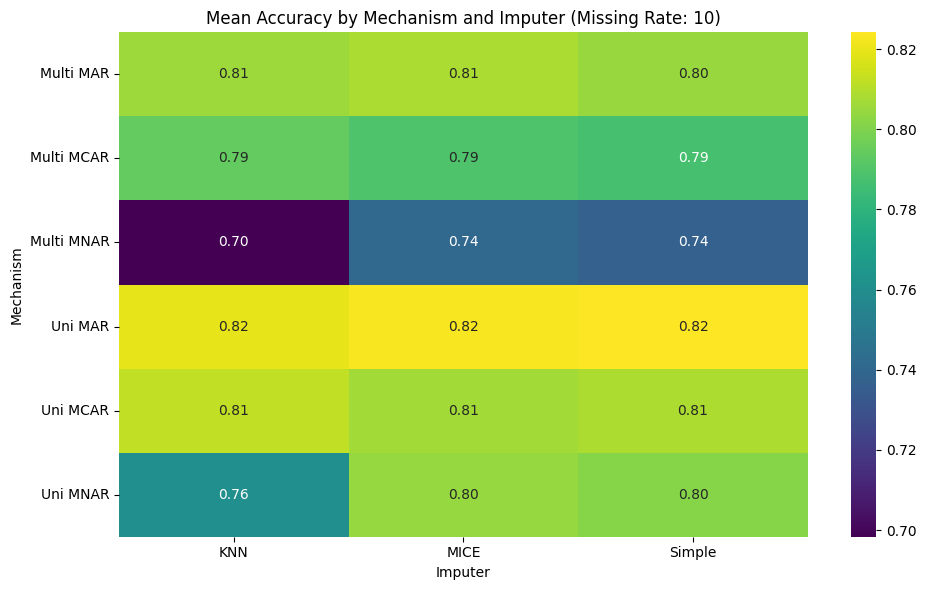

In [48]:
# Pivot the data for plotting
pivot_df = grouped_df.pivot(index='mechanism', columns='imputer', values='mean_accuracy')

# Plot the results
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt=".2f")
plt.title(f'Mean Accuracy by Mechanism and Imputer (Missing Rate: {selected_missing_rate})')
plt.xlabel('Imputer')
plt.ylabel('Mechanism')
plt.tight_layout()
plt.show()

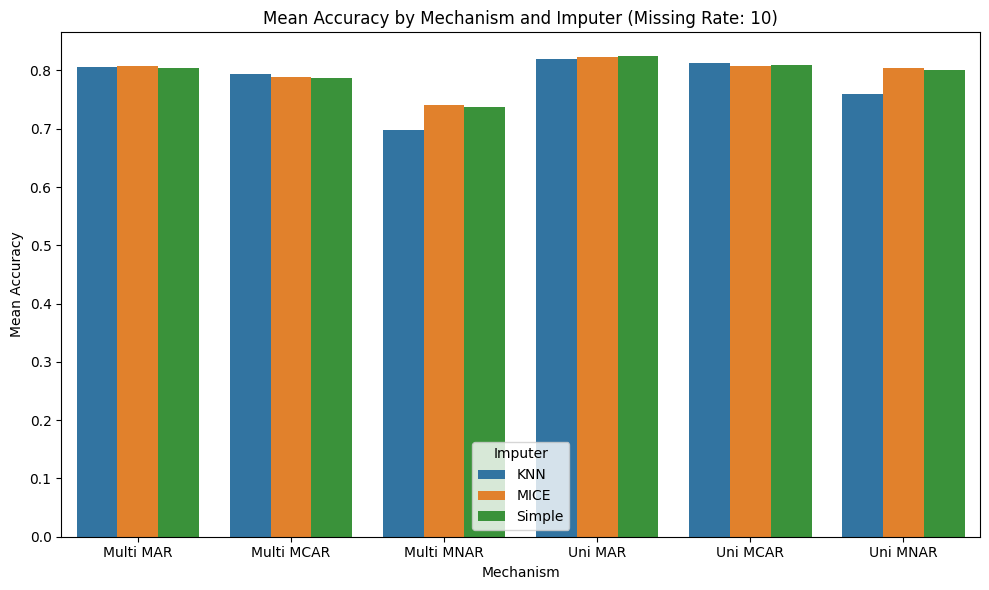

In [49]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=grouped_df,
    x='mechanism',
    y='mean_accuracy',
    hue='imputer',
    errorbar=None,
)
plt.title(f'Mean Accuracy by Mechanism and Imputer (Missing Rate: {selected_missing_rate})')
plt.ylabel('Mean Accuracy')
plt.xlabel('Mechanism')
plt.legend(title='Imputer')
plt.tight_layout()
plt.show()

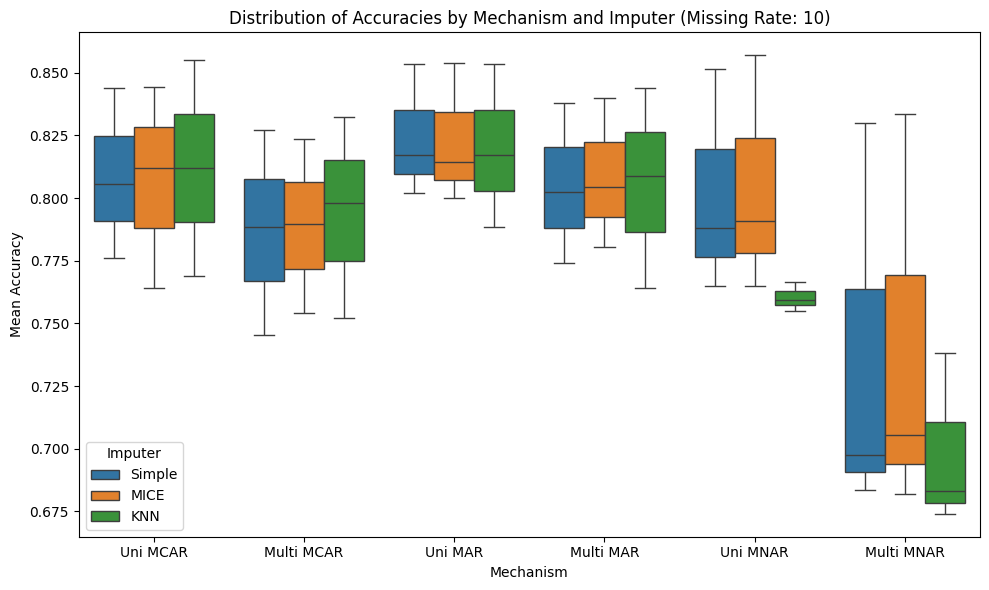

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_results_df,
    x='mechanism',
    y='mean_accuracy',
    hue='imputer'
)
plt.title(f'Distribution of Accuracies by Mechanism and Imputer (Missing Rate: {selected_missing_rate})')
plt.ylabel('Mean Accuracy')
plt.xlabel('Mechanism')
plt.legend(title='Imputer')
plt.tight_layout()
plt.show()


## Predictive Accuracy

In [51]:
print(pac_results)
print(dac_results)
pac_df = pd.DataFrame(pac_results)
pac_df
filtered_pac_df = pac_df[pac_df["missing_rate"] == MISSING_RATES[0]]
filtered_pac_df

[{'imputer': 'Simple', 'mechanism': 'Uni MCAR', 'missing_rate': 10, 'dataset': 'mobile_price', 'numerical_pac': np.float64(2167.16), 'binary_pac': nan}, {'imputer': 'MICE', 'mechanism': 'Uni MCAR', 'missing_rate': 10, 'dataset': 'mobile_price', 'numerical_pac': np.float64(2167.1599979693856), 'binary_pac': nan}, {'imputer': 'KNN', 'mechanism': 'Uni MCAR', 'missing_rate': 10, 'dataset': 'mobile_price', 'numerical_pac': np.float64(2167.096134198271), 'binary_pac': nan}, {'imputer': 'Simple', 'mechanism': 'Multi MCAR', 'missing_rate': 10, 'dataset': 'mobile_price', 'numerical_pac': np.float64(389.39588755886086), 'binary_pac': np.float64(0.5398708800567512)}, {'imputer': 'MICE', 'mechanism': 'Multi MCAR', 'missing_rate': 10, 'dataset': 'mobile_price', 'numerical_pac': np.float64(389.403292400444), 'binary_pac': np.float64(0.5619035306426722)}, {'imputer': 'KNN', 'mechanism': 'Multi MCAR', 'missing_rate': 10, 'dataset': 'mobile_price', 'numerical_pac': np.float64(389.3790134968992), 'binar

,imputer,mechanism,missing_rate,dataset,numerical_pac,binary_pac
0,Simple,Uni MCAR,10,mobile_price,2167.160000,NaN
1,MICE,Uni MCAR,10,mobile_price,2167.159998,NaN
2,KNN,Uni MCAR,10,mobile_price,2167.096134,NaN
3,Simple,Multi MCAR,10,mobile_price,389.395888,0.539871
4,MICE,Multi MCAR,10,mobile_price,389.403292,0.561904
5,KNN,Multi MCAR,10,mobile_price,389.379013,0.536262
6,Simple,Uni MAR,10,mobile_price,1994.460000,NaN
7,MICE,Uni MAR,10,mobile_price,1994.460096,NaN
8,KNN,Uni MAR,10,mobile_price,1994.452535,NaN
9,Simple,Multi MAR,10,mobile_price,647.431429,0.503333


In [52]:
# pd.mean() ignores np.nan values (these correspond, for example, to no missing data generated in binary variables)
grouped_numerical = (
    filtered_pac_df.groupby(["imputer", "mechanism"])["numerical_pac"]
    .mean()
    .reset_index()
)
grouped_binary = (
    filtered_pac_df.groupby(["imputer", "mechanism"])["binary_pac"]
    .mean()
    .reset_index()
)

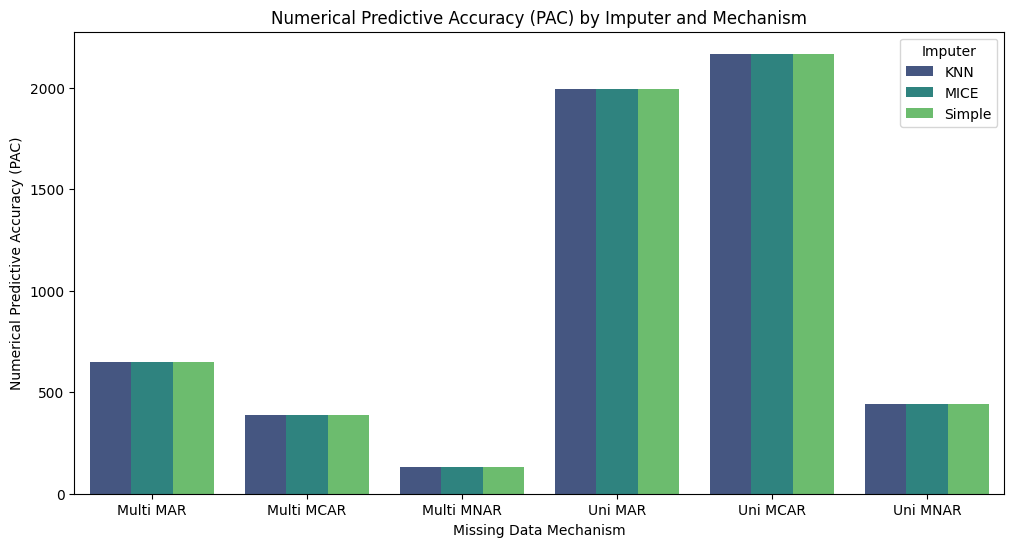

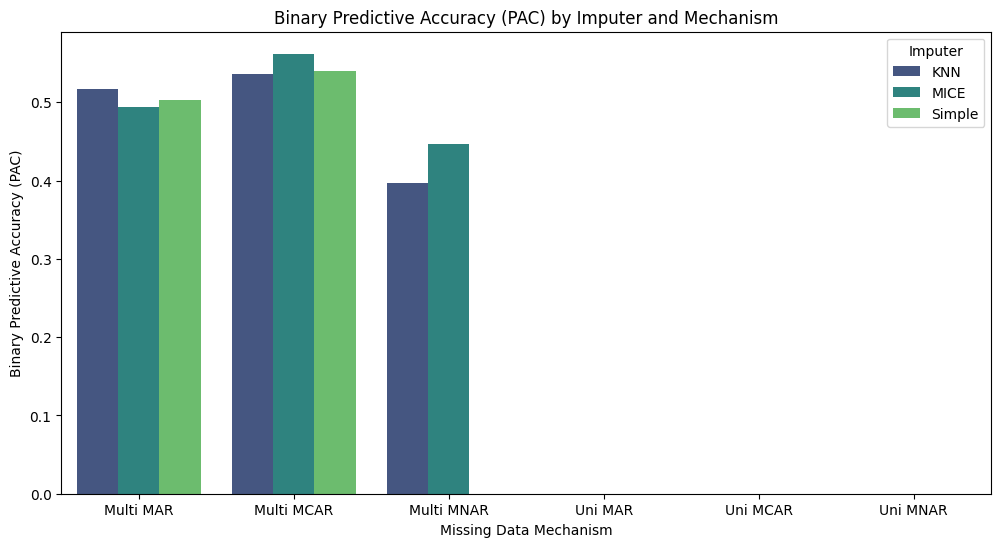

In [53]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_numerical,
    x="mechanism",
    y="numerical_pac",
    hue="imputer",
    palette="viridis",
)
plt.title("Numerical Predictive Accuracy (PAC) by Imputer and Mechanism")
plt.xlabel("Missing Data Mechanism")
plt.ylabel("Numerical Predictive Accuracy (PAC)")
plt.legend(title="Imputer")
plt.show()

# Plot Binary Predictive Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_binary,
    x="mechanism",
    y="binary_pac",
    hue="imputer",
    palette="viridis",
)
plt.title("Binary Predictive Accuracy (PAC) by Imputer and Mechanism")
plt.xlabel("Missing Data Mechanism")
plt.ylabel("Binary Predictive Accuracy (PAC)")
plt.legend(title="Imputer")
plt.show()

## Distributional Accuracy

   imputer   mechanism  missing_rate       dataset  numerical_dac
0   Simple    Uni MCAR            10  mobile_price       1.000000
1     MICE    Uni MCAR            10  mobile_price       1.000000
2      KNN    Uni MCAR            10  mobile_price       1.000000
3   Simple  Multi MCAR            10  mobile_price       0.979532
4     MICE  Multi MCAR            10  mobile_price       0.961649
5      KNN  Multi MCAR            10  mobile_price       0.930091
6   Simple     Uni MAR            10  mobile_price       1.000000
7     MICE     Uni MAR            10  mobile_price       1.000000
8      KNN     Uni MAR            10  mobile_price       1.000000
9   Simple   Multi MAR            10  mobile_price       0.971429
10    MICE   Multi MAR            10  mobile_price       1.000000
11     KNN   Multi MAR            10  mobile_price       0.934286
12  Simple    Uni MNAR            10  mobile_price       1.000000
13    MICE    Uni MNAR            10  mobile_price       1.000000
14     KNN

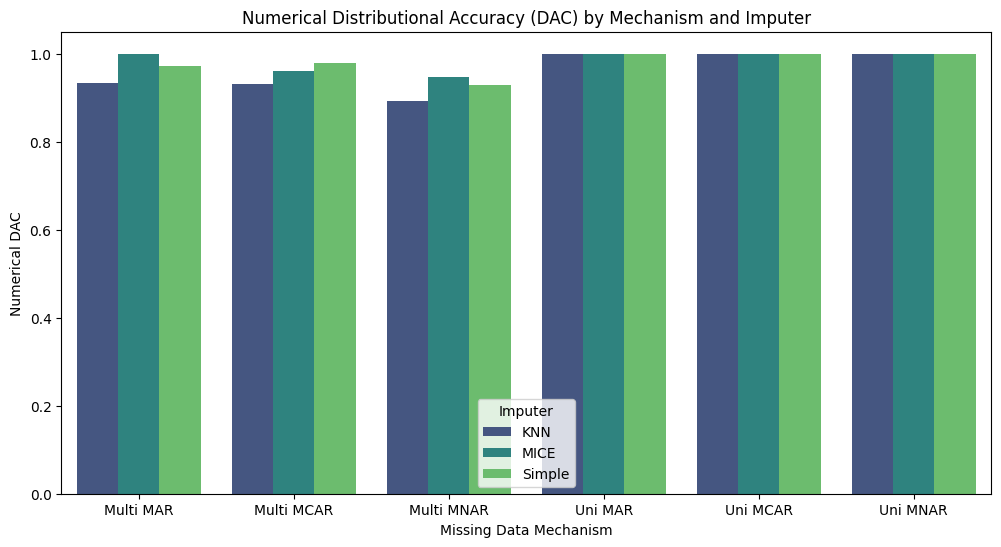

In [54]:
pac_df = pd.DataFrame(dac_results)
print(pac_df)
filtered_df = pac_df[pac_df["missing_rate"] == MISSING_RATES[0]]

# Aggregate by mechanism and imputer (averaging over datasets)
numerical_dac = (
    filtered_df.groupby(["mechanism", "imputer"])["numerical_dac"]
    .mean()
    .reset_index()
)

# Plot Numerical DAC
plt.figure(figsize=(12, 6))
sns.barplot(
    data=numerical_dac,
    x="mechanism",
    y="numerical_dac",
    hue="imputer",
    palette="viridis",
)
plt.title("Numerical Distributional Accuracy (DAC) by Mechanism and Imputer")
plt.xlabel("Missing Data Mechanism")
plt.ylabel("Numerical DAC")
plt.legend(title="Imputer")
plt.show()

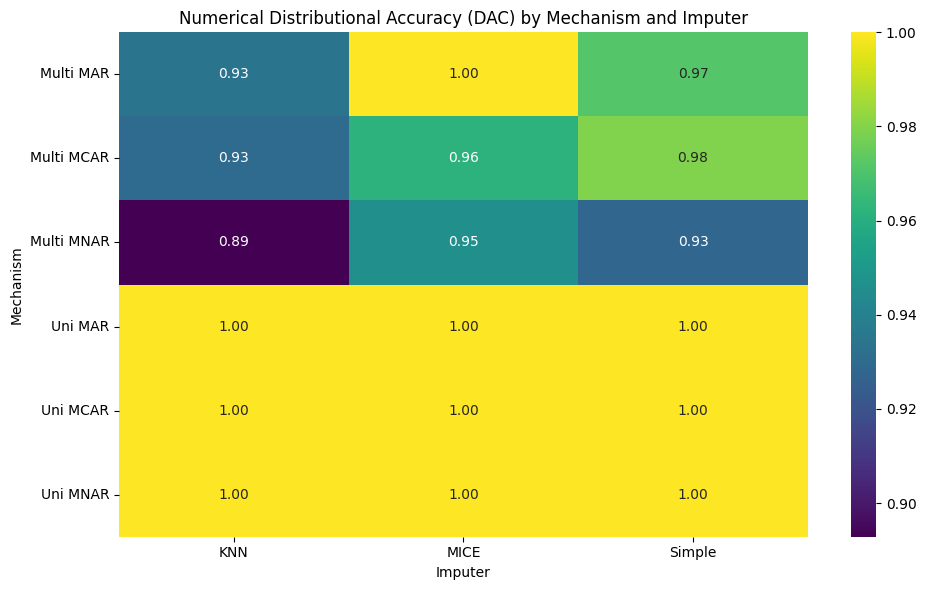

In [55]:
# Pivot the data for numerical DAC
numerical_pivot_df = numerical_dac.pivot(index="mechanism", columns="imputer", values="numerical_dac")

# Plot heatmap for Numerical DAC
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_pivot_df, annot=True, cmap="viridis", fmt=".2f")
plt.title("Numerical Distributional Accuracy (DAC) by Mechanism and Imputer")
plt.xlabel("Imputer")
plt.ylabel("Mechanism")
plt.tight_layout()
plt.show()


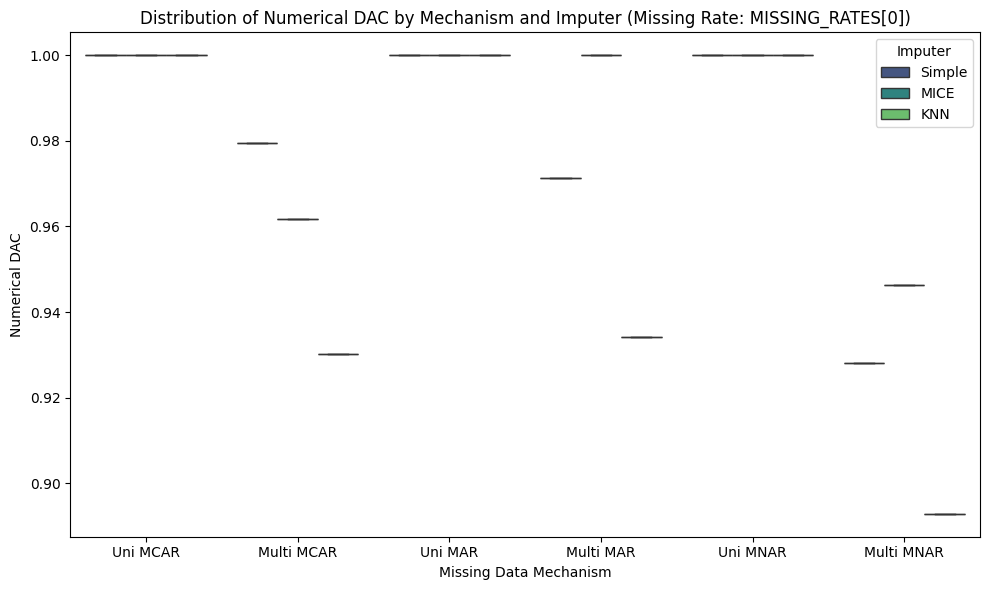

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_df,
    x="mechanism",
    y="numerical_dac",
    hue="imputer",
    palette="viridis"
)
plt.title("Distribution of Numerical DAC by Mechanism and Imputer (Missing Rate: MISSING_RATES[0])")
plt.ylabel("Numerical DAC")
plt.xlabel("Missing Data Mechanism")
plt.legend(title="Imputer")
plt.tight_layout()
plt.show()
